In [1]:
from sklearn.cluster import KMeans
import numpy as np
import datetime
import pandas as pd
import random

In [2]:
X=pd.read_csv('nifty.csv')
len(X)

2966

In [3]:
def data1():
    X=pd.read_csv('nifty.csv')
    # Ensure 'Open' and 'Close' are treated as numeric
    X['Open'] = pd.to_numeric(X['Open'], errors='coerce')
    X['Close'] = pd.to_numeric(X['Close'], errors='coerce')
    X['c-o']=(X.Close-X.Open)/X.Open*100
    X['candle']=np.where(X['c-o'].values<-1,0,np.where(X['c-o'].values<-0.5,1,np.where(X['c-o'].values<0,2,np.where(X['c-o'].values<0.5,3,np.where(X['c-o'].values<1,4,5)))))
    X = X.dropna(axis = 0, how ='any')
    X = X.reset_index()
    X['cashopen']=0
    X['cash']=0
    # Ensure columns have float dtype before assignment
    X['cashopen'] = X['cashopen'].astype(float)
    X['cash'] = X['cash'].astype(float)
    X['action']=""
    X['diff']=""
    X['quantity']=""
    return X
    

In [4]:
X=data1()

In [5]:
print(len(X))

2966


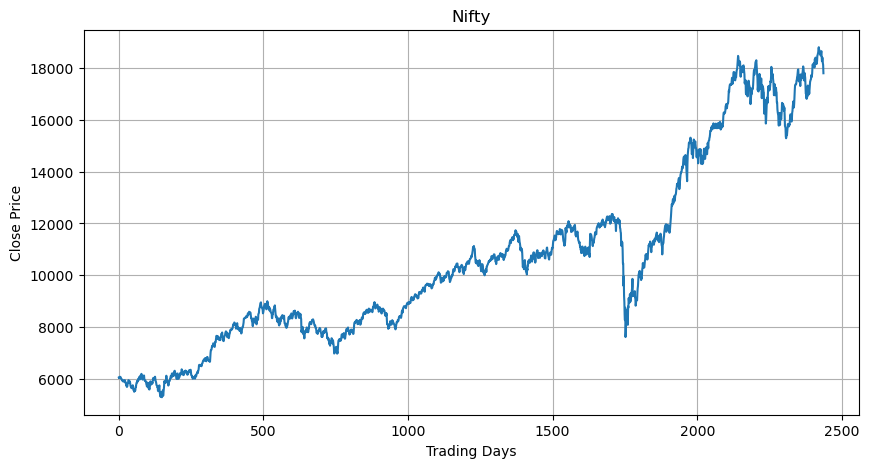

In [6]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
ax=X.loc[1:2436,'Close'].plot(grid="True",figsize=(10,5), title='Nifty')
ax.set_xlabel("Trading Days")
ax.set_ylabel("Close Price")
plt.show()
fig.savefig('nifty_close.png')

In [7]:
X['candle'].value_counts()

candle
2    848
3    812
1    434
4    362
0    298
5    212
Name: count, dtype: int64

In [8]:
#X.head()

In [9]:
def getState(t):    
    return(X['candle'][t])  

In [10]:
class Agent:
    def __init__(self):
        self.epsilon = 1.0
        self.gamma = 0.618
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.Q = np.matrix(np.zeros([6,3]))
        self.learning_rate=0.03
        
    def getAction(self,state):
        a=[1,0,2]
        if np.random.rand() <= self.epsilon:
            return random.choice(a)
        return np.argmax(self.Q[state,])  
    
    # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
    def update(self,state,action,reward,next_state,next_action):
            self.Q[state,action]= self.Q[state,action] + self.learning_rate * (reward + self.gamma * np.max(self.Q[next_state, :])
                                                                - self.Q[state,action])

        

In [ ]:
episode_count=100
agent=Agent()
agent.Q
m1=0
m2=0
for e in range(1,episode_count+1):
    X=data1()
    
    data_length_start=1
    data_length=2436
    state = getState(data_length_start-1)
    action = agent.getAction(state)
    
  
    capital=X.loc[data_length_start,'Open']*10
    margin=X.loc[data_length_start,'Open']*10
    #X.loc[2,'cashopen']=margin 
    X.loc[2, 'cashopen'] = float(margin)
    brok_rate=0.0000
    #brok_rate=0.0
    
    print("Episod {}/{}".format(e,episode_count))
    count=0
    for t in range(data_length_start,data_length-1):
                
        reward=0                        
         
        if action == 1:
            X.loc[t,'cashopen']=float(margin)
            quantity=margin//X.loc[t,'Open']
            X.loc[t,'quantity']=quantity
            margin=margin%X.loc[t,'Open']
            tbrokerage=(X.loc[t,'Open']+X.loc[t,'Close'])*brok_rate
            tprofit=(X.loc[t,'Close']-X.loc[t,'Open']-tbrokerage)*quantity
            margin=margin+tprofit+X.loc[t,'Open']*quantity
            X.loc[t,'cash']=float(margin)         
            
            #print('Long: open price @',X.loc[t,'Open'],'Close price @',X.loc[t,'Close'], 'profit=',tprofit)
            X.loc[t,'action']="long"
            X.loc[t,'diff']=(X.loc[t,'Close']-X.loc[t,'Open']-tbrokerage)*quantity
            count=count+1
            reward= max((np.log(X.loc[t,'Close'])-np.log(X.loc[t,'Open']+tbrokerage)),0)
       
        elif action == 2:
            X.loc[t,'cashopen']=float(margin) 
            quantity=margin//X.loc[t,'Open']
            X.loc[t,'quantity']=(-quantity)
            margin=margin%X.loc[t,'Open']
            tbrokerage=(X.loc[t,'Open']+X.loc[t,'Close'])*brok_rate
            tprofit=(X.loc[t,'Open']-X.loc[t,'Close']-tbrokerage)*quantity
            #print('in Short')
            margin=margin+tprofit+X.loc[t,'Open']*quantity
            X.loc[t,'cash']=float(margin)         
            last_action='Short'
            #print('Short: Close price @',X.loc[t,'Close'],'Open price @',X.loc[t,'Open'], 'profit=',tprofit)
            X.loc[t,'action']="short"
            X.loc[t,'diff']=(X.loc[t,'Open']-X.loc[t,'Close']-tbrokerage)*quantity
            count=count+1
            reward= max((np.log(X.loc[t,'Open'])-np.log(X.loc[t,'Close']+tbrokerage)),0)
        else:
            X.loc[t,'cash']=margin
            X.loc[t,'action']="Hold"
            X.loc[t,'diff']=0
            reward=0                                  
              
        next_state=getState(t)
        next_action=agent.getAction(next_state)
        agent.update(state,action,reward,next_state,next_action)
        state=next_state
        action=next_action
        
        if t==data_length-2:
                print("\n***********************\n")
                print("Profit is ",(margin-capital))
                print("Initial Capital is ",capital)    
                print("Current Capital is ",margin)
                roi=((margin-capital)/capital)*100
                print("%ROI is ",roi)
                bnh=((X.loc[t,'Close']-X.loc[data_length_start,'Open'])/X.loc[data_length_start,'Open'])*100
                print("% Buy and Hold=",bnh)
                print("count",count)
                print("qtable",agent.Q)
                print("epsilon",agent.epsilon)
                print("--------------------------------")
                       
        if (agent.epsilon > agent.epsilon_min) and e>1:
                       agent.epsilon *= agent.epsilon_decay
                       
    
    m3=roi
    if m3>m2:
        m1=e
        m2=m3
    #To save model  
    if e%50==0:
        np.save('rl/Qtable'+ str(e)+str('.npy'), agent.Q)
        np.save('rl/epsilon'+ str(e)+str('.npy'), agent.epsilon)
        np.save('rl/gamma'+ str(e)+str('.npy'), agent.gamma)
        np.save('rl/learning_rate'+ str(e)+str('.npy'), agent.learning_rate)
        X.to_csv('csv1/AfterTrain'+str(e)+str('.csv'))
print("e={},roi={}".format(m1,m2))

Episod 1/100

***********************

Profit is  -5968.938400999934
Initial Capital is  60801.49902
Current Capital is  54832.56061900007
%ROI is  -9.81709085665226
% Buy and Hold= 199.31991650425596
count 1591
qtable [[0.00363479 0.00784101 0.00879363]
 [0.00365312 0.00721252 0.00630596]
 [0.00419635 0.00697387 0.00717465]
 [0.00446753 0.00658515 0.00767402]
 [0.00396077 0.0067928  0.00640314]
 [0.00311416 0.00653021 0.00608941]]
epsilon 1.0
--------------------------------
Episod 2/100

***********************

Profit is  146841.1831409986
Initial Capital is  60801.49902
Current Capital is  207642.68216099858
%ROI is  241.50914945813548
% Buy and Hold= 199.31991650425596
count 2346
qtable [[0.00409373 0.00768368 0.00985276]
 [0.00413387 0.00953398 0.00698921]
 [0.00457746 0.00655031 0.0089801 ]
 [0.00471266 0.00679011 0.00908285]
 [0.00427396 0.00709825 0.00840358]
 [0.0036693  0.00926642 0.00597378]]
epsilon 0.00998645168764533
--------------------------------
Episod 3/100

*******

In [ ]:
agent.Q

In [ ]:
%matplotlib inline
fig = plt.figure()
ax=X.loc[data_length_start:data_length-2,'cash'].plot(grid="True",figsize=(10,5), title='Nifty')
ax.set_xlabel("Trading Days")
ax.set_ylabel("cash")
plt.show()